# 1-4. Basic regression: Predict fuel efficiency

회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 

이와는 달리 분류(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다

(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

***

이 실습은 ```Auto MPG``` 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 

이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 

이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

***

이 예제는 ```tf.keras API```를 사용합니다.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


***
## 5.1 데이터 구하기

먼저 데이터셋을 다운로드합니다.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/user/.keras/datasets/auto-mpg.data'

판다스를 사용하여 데이터를 읽습니다.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


***
## 5.2 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [6]:
dataset = dataset.dropna()

```"Origin"``` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [8]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


***
## 5.3 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

***
## 5.4 데이터 조사하기
훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

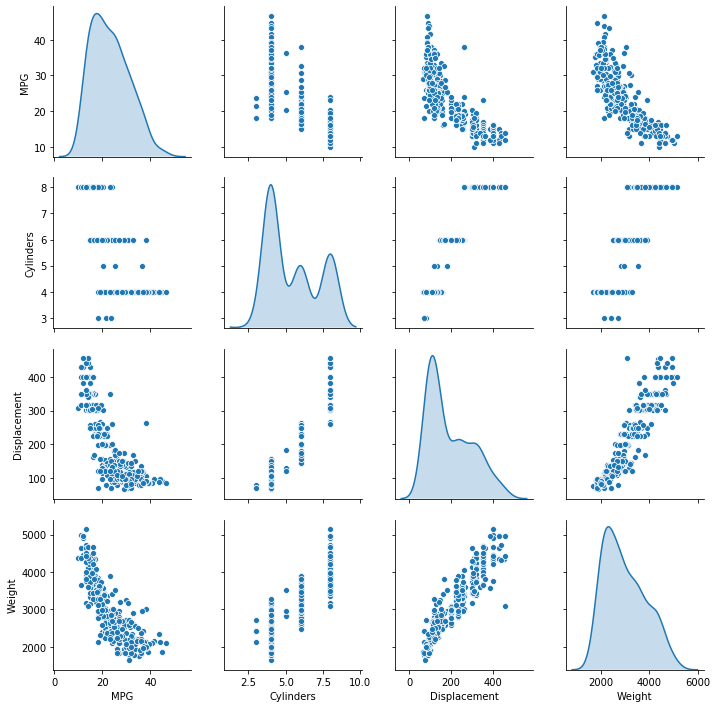

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 확인해 보죠:

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


***
## 5.5 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

***
## 5.6 데이터 정규화

위 train_stats 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 

특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

```
노트: 
의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 
이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 
이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.
```

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

```
주의: 
여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 
여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.
```

***
## 5.7 모델

### 모델 만들기

모델을 구성해 보죠. 

여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들겠습니다. 

출력 층은 하나의 연속적인 값을 반환합니다. 

나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸겠습니다.

In [15]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()

### 모델 확인
```.summary``` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해 보죠. 

훈련 세트에서 10 샘플을 하나의 배치로 만들어 ```model.predict``` 메서드를 호출해 보겠습니다.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.12277368],
       [-0.13850023],
       [-0.02814469],
       [-0.16209055],
       [-0.16112265],
       [ 0.00937492],
       [-0.21603212],
       [-0.43971163],
       [ 0.12065375],
       [-0.22292167]], dtype=float32)

제대로 작동하는 것 같네요. 

결괏값의 크기와 타입이 기대했던 대로입니다.

### 모델 훈련

이 모델을 1,000번의 에포크(epoch) 동안 훈련합니다. 

훈련 정확도와 검증 정확도는 ```history``` 객체에 기록됩니다.

In [20]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [21]:
print(history.history)

{'loss': [575.1833521626385, 531.2301240594263, 487.98839930804127, 438.99632050411634, 385.6434295775881, 328.8167410922715, 271.83495042048605, 217.60296722047357, 167.90803081010918, 125.34232688994996, 91.35854433827191, 66.28509603553559, 48.951420027896226, 37.62965710704545, 30.092069321894552, 24.462342516834518, 20.3867790062589, 17.53622968833285, 15.664486049180962, 14.048133177586285, 12.937571867528664, 11.94068946686399, 11.188474943913311, 10.791742037966907, 10.184279259457531, 9.983682446270825, 9.4405546131362, 9.19463825415805, 8.945838863631169, 8.68165615355351, 8.401172746225182, 8.385406794301067, 8.226993891347451, 8.057937656265805, 7.9867521966121116, 7.820914933406025, 7.732655699984486, 7.681367323218113, 7.777572276582756, 7.592959172222244, 7.5103954565952495, 7.369735998936384, 7.415729422018347, 7.377597417489466, 7.311219076711343, 7.153360530199758, 7.241139905861174, 7.097559763615825, 7.032987784579456, 7.292446404339308, 7.047956622454275, 6.8755958

```history``` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.402513,0.980944,2.402513,11.003591,2.575393,11.003591,995
996,2.532375,0.955426,2.532375,10.917760,2.563999,10.917761,996
997,2.302651,0.927244,2.302651,11.113595,2.611577,11.113595,997
998,2.404954,0.982247,2.404954,10.034435,2.456863,10.034435,998
999,2.411589,1.013017,2.411589,10.742013,2.503637,10.742013,999


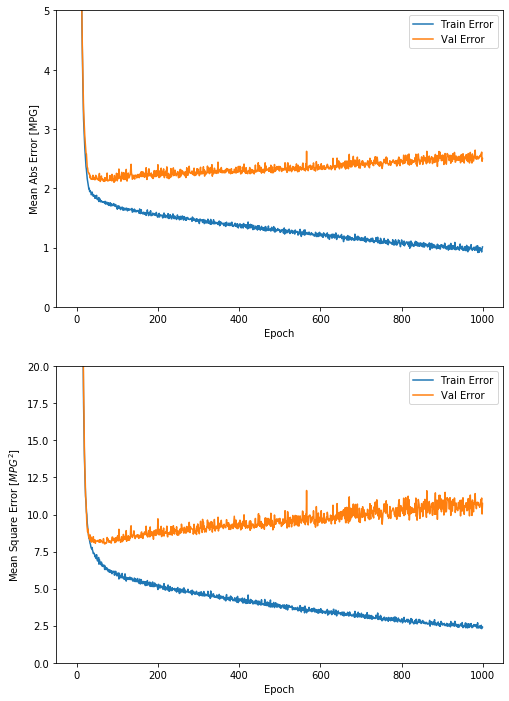

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. 

```model.fit``` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 

에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다. 

지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.


.....................................................

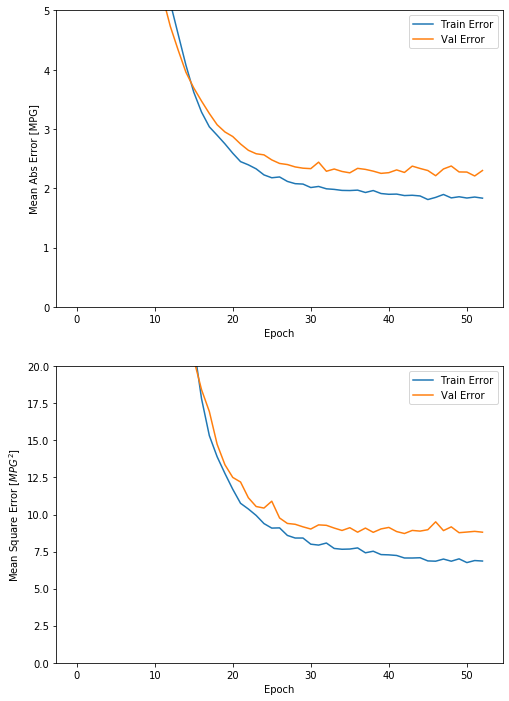

In [24]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 

좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 

이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.1120 - mae: 1.8981 - mse: 6.1120
테스트 세트의 평균 절대 오차:  1.90 MPG


***
## 5.8 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

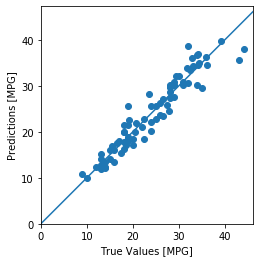

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 꽤 잘 예측한 것 같습니다. 

오차의 분포를 살펴 보죠.

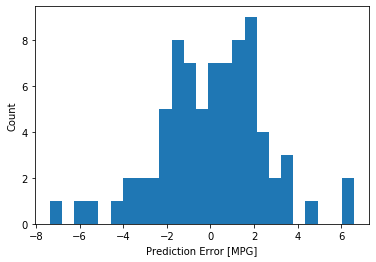

In [28]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

***
## 5.9 결론

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

   * 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
   
   * 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
   
   * 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
   
   * 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
   
   * 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.